### Imports and preprocessing

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree
from sklearn.preprocessing import normalize

import typing
import os
import sys

from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive
from zipfile import ZipFile

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# truth
TRUTH_DATASET = 'ground_truth_color'

with ZipFile(f'/content/gdrive/MyDrive/{TRUTH_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{TRUTH_DATASET}')

# compressed
COMPRESSED_DATASET = 'compressed'

with ZipFile(f'/content/gdrive/MyDrive/{COMPRESSED_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{COMPRESSED_DATASET}')

# restored AR-CNN
ARCNN_DATASET = 'results_ARCNN'

with ZipFile(f'/content/gdrive/MyDrive/{ARCNN_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{ARCNN_DATASET}')

# restored FBCNN
FBCNN_DATASET = 'results_FBCNN'

with ZipFile(f'/content/gdrive/MyDrive/{FBCNN_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{FBCNN_DATASET}')

# restored DNCNN3
DNCNN_DATASET = 'results_DNCNN3'

with ZipFile(f'/content/gdrive/MyDrive/{DNCNN_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{DNCNN_DATASET}')

#### functions

In [2]:
def set_coord_des(kp, des):
    coord = {}
    descript = {}
    for i in range(len(kp)):
        coord[i] = np.array(kp[i].pt)

        descript[i] = des[i]
    return coord, descript

def get_key(d, value):
    for k, v in d.items():
        if np.array_equal(v, value):
            return k

def get_matches_with_scipy(kp_idx1: dict, kp_idx2: dict, radius = 1):
    """
    get simple matches for two dict of coordinates of features of images
    """
    matches = {}
    to_delete = -1
    for k1, v1 in kp_idx1.items():
        # finding nearest with KDTree
        tree = KDTree(list(kp_idx2.values()))
        nearest = tree.query(v1)

        if nearest[0] < radius:
            # key of the nearest in kp_idx2
            k2 = get_key(kp_idx2, list(kp_idx2.values())[nearest[1]])

            # save matching
            matches[k1] = k2

            # clear a little bit kp_idx2
            del kp_idx2[k2]

    return matches

def get_cross_matches(matches1, matches2):
    """
    calculate cross match features
    """
    cross_matches = 0
    for k1, v1 in matches1.items():
        if v1 in matches2:
            if matches2[v1] == k1:
                cross_matches += 1
    return cross_matches

def coordinates_match(img1, img2, radius = 1, cross_match = False):
    """
    SIFT calculated features
    feature matching using l2 metric of coordinates
    """
    print('images shape:', img1.shape)

    # SIFT feature detector
    sift = cv2.SIFT_create(nfeatures=10000)
    kp_im1, des_im1 = sift.detectAndCompute(img1, None)
    kp_im2, des_im2 = sift.detectAndCompute(img2, None)

    # get coordinates and descriptors of features and set index
    coord_1, descript_1 = set_coord_des(kp_im1, des_im1)
    coord_2, descript_2 = set_coord_des(kp_im2, des_im2)
    all_features = len(coord_2)

    print('radius value:', radius)
    print('number of features for img1:', len(coord_1))
    print('number of features for img2:', all_features)

    if not cross_match:
        im1_VS_im2_match = get_matches_with_scipy(coord_1, coord_2, radius = radius)
        print('number of matching:', len(im1_VS_im2_match))

    if cross_match:
        # simple match
        im1_VS_im2_match = get_matches_with_scipy(coord_1, coord_2, radius = radius)
        coord_2, descript_2 = set_coord_des(kp_im2, des_im2)
        im2_VS_im1_match = get_matches_with_scipy(coord_2, coord_1, radius = radius)

        # cross_match
        cross_matches = get_cross_matches(im1_VS_im2_match, im2_VS_im1_match)
        cross_match_value = cross_matches/all_features

        print('number of img1 VS img2 matching:', len(im1_VS_im2_match))
        print('number of img2 VS img1 matching:', len(im2_VS_im1_match))
        print('cross match value:', cross_match_value)

    return cross_match_value

In [3]:
def get_list_with_path(folder_path):
    '''
    input: path to folder with images
    output: list with path to images in folder
    '''
    path_list = []
    for image in os.listdir(folder_path):
        path_list.append(folder_path + '/' + image)
    return sorted(path_list)

def coordinates_batch_match(pack1_path, pack2_path, radius = 1, cross_match = False):
    '''
    coordinates based match for package

    input: path to folder with images
    output: list with match values
    '''
    match_values = []
    pack1_images = get_list_with_path(pack1_path)
    pack2_images = get_list_with_path(pack2_path)
    for i in range(len(pack1_images)):
        img1 = cv2.imread(pack1_images[i])
        img2 = cv2.imread(pack2_images[i])
        print('#'*50)
        print('image', i)
        print()
        value = coordinates_match(img1, img2, radius = radius, cross_match=cross_match)
        print()
        match_values.append(value)
    return match_values

## metric

#### experiment with one image

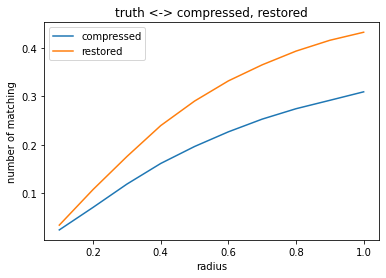

In [ ]:
logg_path = 'logg.txt'
with open(logg_path, 'w+') as file:
    pass
try:
    sys.stdout = open(logg_path, "w")

    num_matches_comp = []
    num_matches_rest = []

    # matching
    x = np.arange(0.1, 1.1, 0.1)
    for r in x:
        print('#'*50)
        print('truth and compressed matching:')
        print()
        tr_comp_coord_matches, tr_comp_value = coordinates_match(tr, comp, radius = r, cross_match=True)
        print()
        print()
        print('truth and restored matching:')
        print()
        tr_rest_coord_matches, tr_rest_value = coordinates_match(tr, rest, radius = r, cross_match=True)

        num_matches_comp.append(tr_comp_value)
        num_matches_rest.append(tr_rest_value)

    # plot number of matches
    plt.figure(1)
    plt.xlabel('radius')
    plt.ylabel('number of matching')
    plt.title('truth <-> compressed, restored')
    y1 = num_matches_comp
    y2 = num_matches_rest
    plt.plot(x, y1, label = 'compressed')
    plt.plot(x, y2, label = 'restored')
    plt.legend()

finally:
    sys.stdout.close()  
    sys.stdout = sys.__stdout__

In [ ]:
files.download('logg.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### calculate metric for AR-CNN, FBCNN, DNCNN3

In [ ]:
%%time
# 0-25 (done) --> 25-50 (done) --> 50-100 (done)

# AR-CNN
arcnn_values = coordinates_batch_match('/content/ground_truth_color', 
                                       '/content/results_ARCNN', 
                                       radius = 1, cross_match=True)

# in this foulder will save results
if not os.path.exists('/content/results'):
    os.mkdir('/content/results')

np.save('/content/results/sift_arcnn_50_100.npy', arcnn_values)
files.download('/content/results/sift_arcnn_50_100.npy')

##################################################
image 0

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10001
number of img1 VS img2 matching: 4892
number of img2 VS img1 matching: 4890
cross match value: 0.4844515548445156

##################################################
image 1

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 4903
number of img2 VS img1 matching: 4902
cross match value: 0.4847

##################################################
image 2

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 4902
number of img2 VS img1 matching: 4903
cross match value: 0.485

##################################################
image 3

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of f

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 3h 15min 12s, sys: 34.6 s, total: 3h 15min 46s
Wall time: 3h 15min 23s


In [ ]:
%%time

# DNCNN3
dncnn_values = coordinates_batch_match('/content/ground_truth_color', 
                                       '/content/results_DNCNN3', 
                                       radius = 1, cross_match=True)

# in this foulder will save results
if not os.path.exists('/content/results'):
    os.mkdir('/content/results')
    
np.save('/content/results/sift_dncnn_0_100.npy', dncnn_values)
files.download('/content/results/sift_dncnn_0_100.npy')

##################################################
image 0

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 5012
number of img2 VS img1 matching: 5012
cross match value: 0.4959

##################################################
image 1

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 5072
number of img2 VS img1 matching: 5071
cross match value: 0.5014

##################################################
image 2

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 5069
number of img2 VS img1 matching: 5069
cross match value: 0.5007

##################################################
image 3

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 5h 52min 35s, sys: 1min, total: 5h 53min 35s
Wall time: 5h 52min 13s


In [ ]:
%%time

# FBCNN
fbcnn_values = coordinates_batch_match('/content/ground_truth_color', 
                                       '/content/results_FBCNN', 
                                       radius = 1, cross_match=True)

# in this foulder will save results
if not os.path.exists('/content/results'):
    os.mkdir('/content/results')
    
np.save('/content/results/sift_fbcnn_0_100.npy', fbcnn_values)
files.download('/content/results/sift_fbcnn_0_100.npy')

##################################################
image 0

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 5228
number of img2 VS img1 matching: 5228
cross match value: 0.5173

##################################################
image 1

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 5151
number of img2 VS img1 matching: 5151
cross match value: 0.5107

##################################################
image 2

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of img1 VS img2 matching: 5187
number of img2 VS img1 matching: 5187
cross match value: 0.5127

##################################################
image 3

images shape: (1536, 2048, 3)
radius value: 1
number of features for img1: 10000
number of features for

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 6h 29min 10s, sys: 1min 9s, total: 6h 30min 20s
Wall time: 6h 29min 2s


### histogram/distribution plot for one image

##### functions

In [ ]:
def hist_coord_dist(matches: dict, eps = 2, bins = 20):
    """
    input: {(x11, y11): (x12, y12), ...}
    output: histogram/distribution plot
    """
    distance_data = []
    for coord1, coord2 in matches.items():
        distance_data.append(round(np.linalg.norm(np.array(coord1) - np.array(coord2)), eps))
    data = pd.DataFrame({'Distance': distance_data})

    sns.displot(data, bins = bins)
    plt.show()
    return data

def get_idx_cross_matches(matches1, matches2):
    """
    calculate cross match features
    return matching idx
    """
    cross_matches = {}
    for k1, v1 in matches1.items():
        if v1 in matches2:
            if matches2[v1] == k1:
                cross_matches[v1] = k1
    return cross_matches

def dist_between_matched_descriptors(img1, img2, radius=1):
    # SIFT feature detector
    sift = cv2.SIFT_create(10000)
    kp_im1, des_im1 = sift.detectAndCompute(img1, None)
    kp_im2, des_im2 = sift.detectAndCompute(img2, None)

    # get coordinates and descriptors of features and set index
    coord_1, descript_1 = set_coord_des(kp_im1, des_im1)
    coord_2, descript_2 = set_coord_des(kp_im2, des_im2)

    print('radius value:', radius)
    print('number of features:', len(coord_1))

    im1_VS_im2_match = get_matches_with_scipy(coord_1, coord_2, radius = radius)
    coord_1, descript_1 = set_coord_des(kp_im1, des_im1)
    coord_2, descript_2 = set_coord_des(kp_im2, des_im2)
    im2_VS_im1_match = get_matches_with_scipy(coord_2, coord_1, radius = radius)

    # cross_match
    cross_matches = get_idx_cross_matches(im1_VS_im2_match, im2_VS_im1_match)

    print('number of matching features:', len(cross_matches))

    coord_1, descript_1 = set_coord_des(kp_im1, des_im1)
    coord_2, descript_2 = set_coord_des(kp_im2, des_im2)

    return cross_matches, descript_1, descript_2

##### coordinate distance between matching features in 1 pixel radius

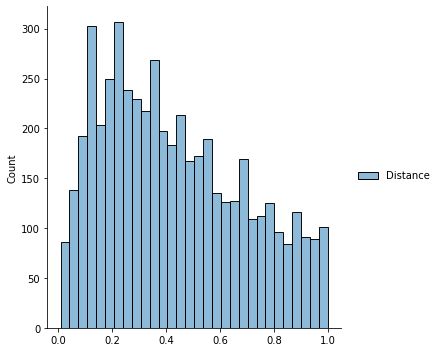

In [ ]:
# truth <-> compressed 
distance_data = []
for coord1, coord2 in tr_comp_coord_matches.items():
    distance_data.append(round(dist(coord1, coord2, 'coord'), 4))
data = pd.DataFrame({'Distance': distance_data})

sns.displot(data, bins = 30)
plt.show()

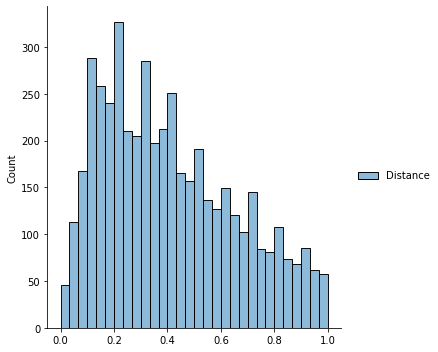

In [ ]:
# truth <-> compressed 
distance_data = []
for coord1, coord2 in tr_rest_coord_matches.items():
    distance_data.append(round(dist(coord1, coord2, 'coord'), 4))
data = pd.DataFrame({'Distance': distance_data})

sns.displot(data, bins = 30)
plt.show()

##### distance between matching descriptors

In [ ]:
def get_des_dist_data(img1, img2, name, radius=1, to_norm=False):
    matches, des1, des2 = dist_between_matched_descriptors(img1, img2, radius=radius)

    des_dist = []
    for k, v in matches.items():
        if k in des1:
            v1 = des1[k]
        else:
            v1 = des2[k]
        if v in des1:
            v2 = des1[v]
        else:
            v2 = des2[v]

        if to_norm:
            v1 = normalize(v1.reshape(1, -1))[0]
            v2 = normalize(v2.reshape(1, -1))[0]

        s = 0
        for coord in v1 - v2:
            s += coord**2

        s = (s/len(v1))**(0.5)
        des_dist.append(s)

    data = pd.DataFrame({f'{name} desc dist, rad={radius}, mean={round(np.mean(des_dist), 4)}': des_dist})
    return data

new

In [ ]:
truth_im = cv2.imread('/content/truth.tiff')
comp_im = cv2.imread('/content/compressed.jpg')
arcnn_im = cv2.imread('/content/restored_arcnn.png')
fbcnn_im = cv2.imread('/content/restored_fbcnn.png')

print('ARCNN')
arcnn_1 = get_des_dist_data(truth_im, arcnn_im, name='arcnn', radius=1, to_norm=True)
arcnn_10 = get_des_dist_data(truth_im, arcnn_im, name='arcnn', radius=10, to_norm=True)

print('\n', 'FBCNN')
fbcnn_1 = get_des_dist_data(truth_im, fbcnn_im, name='fbcnn', radius=1, to_norm=True)
fbcnn_10 = get_des_dist_data(truth_im, fbcnn_im, name='fbcnn', radius=10, to_norm=True)

print('\n', 'Compressed')
comp_1 = get_des_dist_data(truth_im, comp_im, name='comp', radius=1, to_norm=True)
comp_10 = get_des_dist_data(truth_im, comp_im, name='comp', radius=10, to_norm=True)

ARCNN
radius value: 1
number of features: 10000
number of matching features: 4853
radius value: 10
number of features: 10000
number of matching features: 2899

 FBCNN
radius value: 1
number of features: 10000
number of matching features: 5173
radius value: 10
number of features: 10000
number of matching features: 2475

 Compressed
radius value: 1
number of features: 10000
number of matching features: 4529
radius value: 10
number of features: 10000
number of matching features: 2907


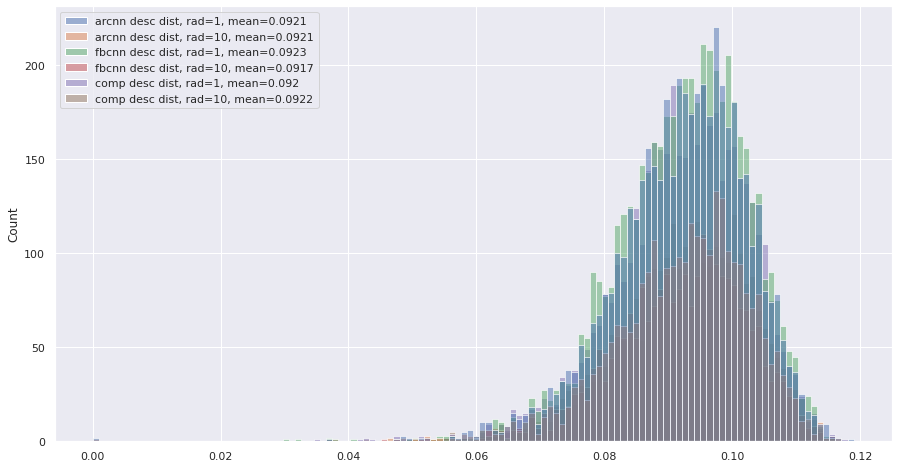

In [ ]:
descriptor_dist = pd.concat([arcnn_1, arcnn_10, fbcnn_1, fbcnn_10, comp_1, comp_10], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)

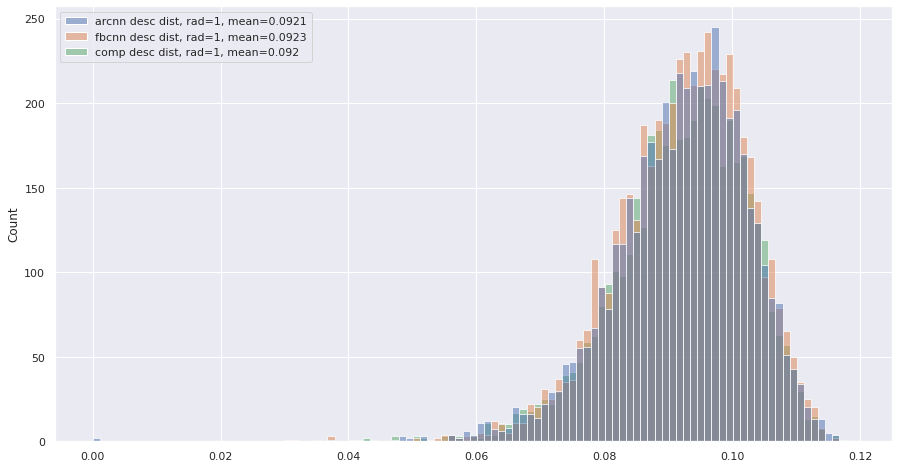

In [ ]:
descriptor_dist = pd.concat([arcnn_1, fbcnn_1, comp_1], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)

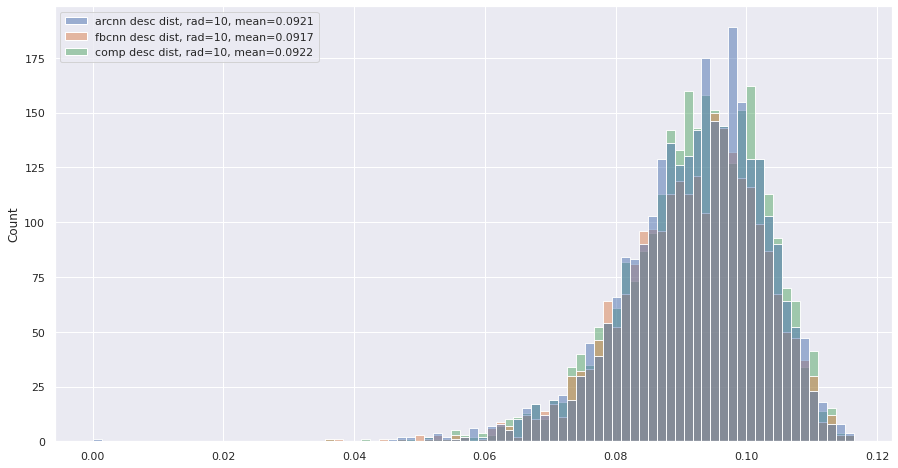

In [ ]:
descriptor_dist = pd.concat([arcnn_10, fbcnn_10, comp_10], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)

##### to look at SIFT features + BruteForce mathcing

In [8]:
def sift_features_BF_matching(img1, img2, num_matches=100, name=''):
    sift = cv2.SIFT_create(10000)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)

    matches = sorted(matches, key = lambda x:x.distance)
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:num_matches], img2, flags=2)
    cv2.imwrite(f"SIFT_BF_match_{name}.png", matched_img)

In [11]:
truth = cv2.imread('/content/truth.tiff')
compressed = cv2.imread('/content/compressed.jpg')
arcnn = cv2.imread('/content/restored_arcnn.png')
dncnn = cv2.imread('/content/restored_dncnn.png')
fbcnn = cv2.imread('/content/restored_fbcnn.png')

truth_comp = sift_features_BF_matching(truth, compressed, num_matches = 850, name = 'truth_comp')
truth_comp = sift_features_BF_matching(truth, arcnn, num_matches = 850, name = 'truth_arcnn')
truth_comp = sift_features_BF_matching(truth, dncnn, num_matches = 850, name = 'truth_dncnn')
truth_comp = sift_features_BF_matching(truth, fbcnn, num_matches = 850, name = 'truth_fbcnn')

### batch metric

In [ ]:
# if need to load from google drive
drive.mount('/content/gdrive')

results = 'sift_arcnn_10000'
with ZipFile(f'/content/gdrive/MyDrive/{results}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/results')

results = 'sift_dncnn_10000'
with ZipFile(f'/content/gdrive/MyDrive/{results}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/results')

results = 'sift_fbcnn_10000'
with ZipFile(f'/content/gdrive/MyDrive/{results}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/results')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


mean value

In [ ]:
arcnn = np.array(list(map(float, np.load('/content/sift_arcnn_10000.npy'))))
dncnn = np.array(list(map(float, np.load('/content/sift_dncnn_10000.npy'))))
fbcnn = np.array(list(map(float, np.load('/content/sift_fbcnn_10000.npy'))))

print('ARCNN mean value:', np.mean(arcnn))
print('DNCNN3 mean value:', np.mean(dncnn))
print('FBCNN mean value:', np.mean(fbcnn))

ARCNN mean value: 0.482639762919169
DNCNN3 mean value: 0.4974760297970204
FBCNN mean value: 0.5072654212385871


histograms

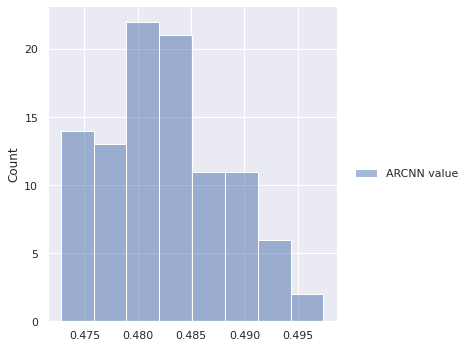

In [ ]:
data = pd.DataFrame({'ARCNN value': arcnn})
displot = sns.displot(data)
plt.show()

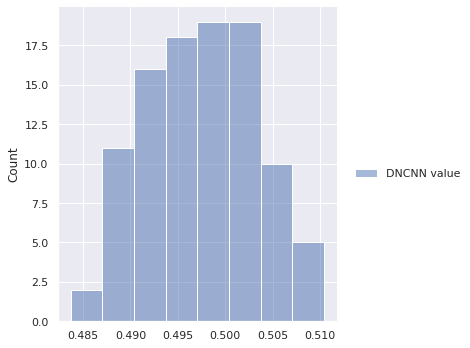

In [ ]:
data = pd.DataFrame({'DNCNN value': dncnn})
displot = sns.displot(data)
plt.show()

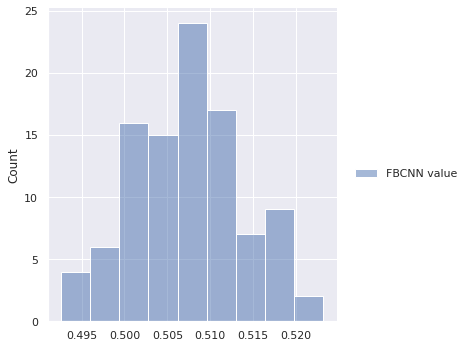

In [ ]:
data = pd.DataFrame({'FBCNN value': fbcnn})
displot = sns.displot(data)
plt.show()

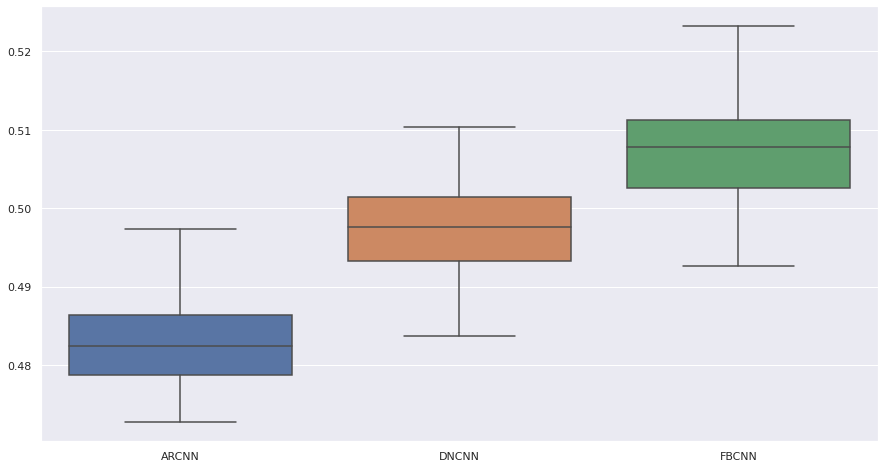

In [ ]:
data = pd.DataFrame({'ARCNN': arcnn, 'DNCNN': dncnn, 'FBCNN': fbcnn})
sns.boxplot(data = data)
plt.show()